# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [100]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [101]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [102]:
# Your code here:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [103]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [104]:
null_cols = customers.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

In [105]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [106]:
stats = customers.describe().transpose()
stats['IQR'] = stats['75%'] - stats['25%']
stats

,count,mean,std,min,25%,50%,75%,max,IQR
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0,1.00
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0,1.00
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0,13806.00
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0,5657.25
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0,8502.75
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0,2812.00
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0,3665.25
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0,1412.00


In [134]:
outliers = pd.DataFrame(columns = customers.columns)

for col in stats.index:
    iqr = stats.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats.at[col,'25%'] - cutoff
    upper = stats.at[col,'75%'] + cutoff
    results = customers[(customers[col] < lower) | 
                   (customers[col] > upper)].copy()
    results['Outlier'] = col
    outliers = outliers.append(results)
    

In [108]:
outliers.head()

,Channel,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk,Outlier,Region
29,1,823,1107,43088,1200,2609,2100,Fresh,3
39,1,2916,212,56159,10002,902,555,Fresh,3
47,2,6465,24171,44466,7782,55571,54259,Fresh,3
52,2,1278,2587,40721,532,5876,3916,Fresh,3
87,1,14351,1579,43265,6312,8117,5025,Fresh,3


In [109]:
#customers['Channel'].unique()
customers['Region'].unique() #se han comprobado también las demás columnas

array([3, 1, 2])

In [110]:
customer_corr = customers.corr()
customer_corr

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


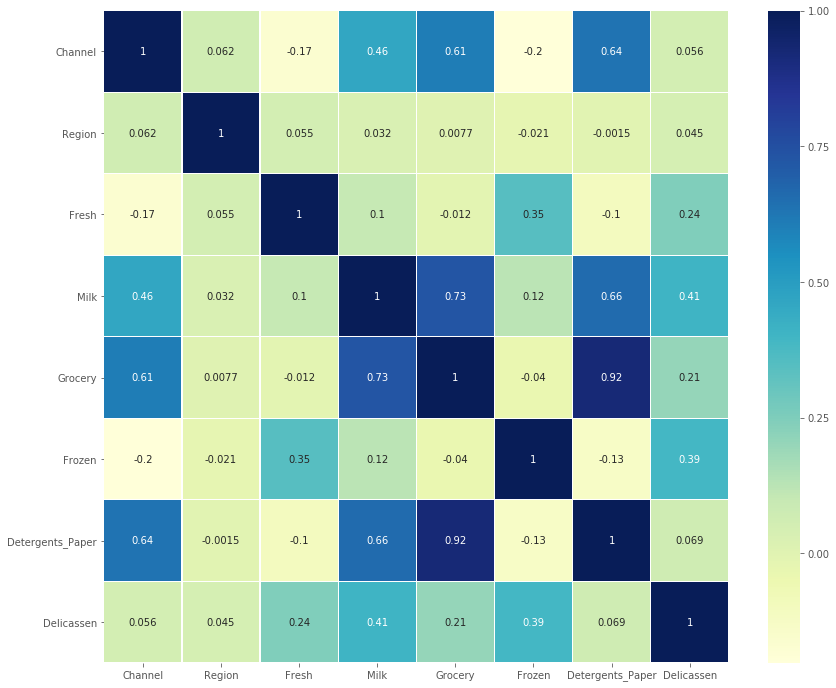

In [111]:
plt.figure(figsize = (14,12))
sns.heatmap(customer_corr, linewidths =.2 ,cmap = 'YlGnBu', annot = True)
plt.yticks(rotation = 0);

In [112]:
# Your observations here
# Todas las columnas son numéricas
# Existe una diferencia alta entre los valores de las columnas. Se debería normalizar
# Existe alta correlación entre Grocery y Detergents_Paper, así que se podría eliminar una de las dos
# No hay que convertir datos categóricos
# No faltan datos
# Existen outliers

In [113]:
# Channel - Identifica al canal de venta
# Region - Identifica la región de venta de un determinado canal
# Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen - Identifica a los departamentos o secciones
# y el valor que ofrece es la cantidad de ventas anuales
# Una descripción más detallada se puede ver en el link del dataset

### Pareto 

In [114]:
customers_pareto = customers.copy()
customers_pareto['total'] = customers_pareto[customers.columns[2:]].sum(axis = 1)

total_ventas = customers_pareto['total'].sum()
num_clientes_20 = customers_pareto.shape[0] * 20 / 100

ordenados_compras = customers_pareto.sort_values(by = 'total', ascending = False)
mas_compran_20 = ordenados_compras['total'][:int(num_clientes_20)].sum()

porcentaje = (mas_compran_20 * 100 / total_ventas )

print('Total de ventas: {} \nTotal de compras del 20% de clientes que más compran: {}'. format(total_ventas, mas_compran_20))
print('Porcentaje del total: {:.2f}'.format(porcentaje))

Total de ventas: 14619500 
Total de compras del 20% de clientes que más compran: 6272473
Porcentaje del total: 42.90


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [115]:
# Your code here

In [116]:
# Your comment here
# Probando dejando outliers y alta correlación entre dos columnas

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [117]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()
scaler.fit(customers)
customers_scale = scaler.transform(customers)

/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sergio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [118]:
# Your code here:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4)
temp = kmeans.fit(customers_scale)
customers['labels'] = temp.labels_

Count the values in `labels`.

In [119]:
# Your code here:
customers['labels'].value_counts()

1    294
3    130
0     10
2      6
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [120]:
# Your code here
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 0.5)
temp_dbscan = dbscan.fit(customers_scale)
customers['labels_DBSCAN'] = temp_dbscan.labels_

Count the values in `labels_DBSCAN`.

In [121]:
# Your code here
customers['labels_DBSCAN'].value_counts()

-1    255
 1    130
 5     22
 4      7
 6      6
 2      5
 7      5
 3      5
 0      5
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

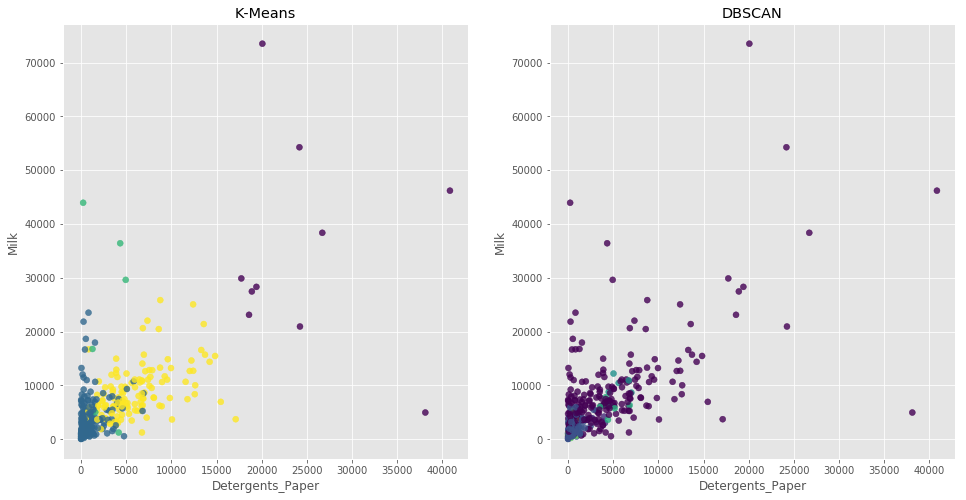

In [122]:
# Your code here:
def graficas(columnas):
    '''
    Pinta las gráficas con las columnas dadas
    Solo permite dos columnas
    0: x
    1: y
    '''
    puntos = [customers['labels'], customers['labels_DBSCAN']]
    titulos = ['K-Means', 'DBSCAN']
    
    f, axs = plt.subplots(figsize = (16, 8))
    
    for i in range(1,len(puntos) + 1):
        plt.style.use('ggplot')
        plt.subplot(1, 2, i)
        plt.scatter(columnas[0], 
                    columnas[1], 
                    c = puntos[i-1], alpha = 0.8)
        plt.title(titulos[i-1])
        plt.xlabel(columnas[0].name)
        plt.ylabel(columnas[1].name)

    
columnas = [customers['Detergents_Paper'], customers['Milk']]
graficas(columnas)

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

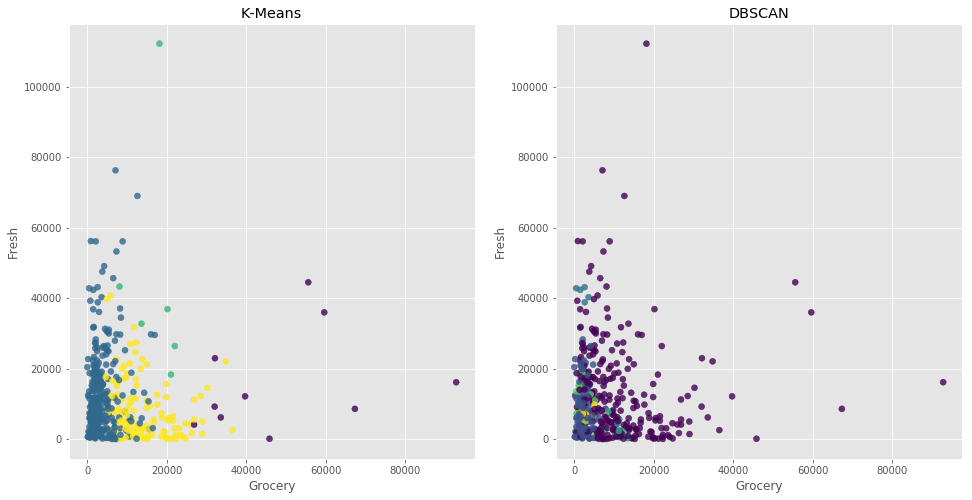

In [123]:
# Your code here:
columnas = [customers['Grocery'], customers['Fresh']]
graficas(columnas)

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

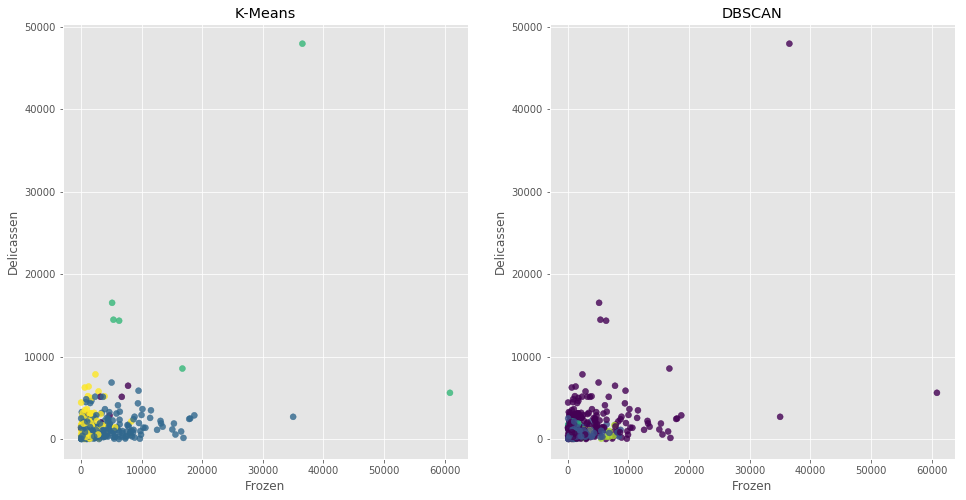

In [124]:
# Your code here:
columnas = [customers['Frozen'], customers['Delicassen']]
graficas(columnas)

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [125]:
# Your code here:
customers_kmean = customers.groupby(customers['labels']).mean()
customers_dbscan = customers.groupby(customers['labels_DBSCAN']).mean()

display(customers_kmean)
display(customers_dbscan)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
labels,,,,,,,,,,
0,2.000000,2.500000,15964.900000,34708.500000,48536.900000,3054.600000,24875.200000,2942.800000,0,-1.000000
1,1.003401,2.503401,12888.670068,3173.095238,3749.513605,3410.561224,760.911565,1137.809524,1,0.663265
2,1.166667,2.833333,44940.666667,22179.166667,17187.000000,21831.166667,2758.000000,17908.000000,2,-1.000000
3,2.000000,2.623077,8165.915385,8748.515385,13905.492308,1441.630769,5991.146154,1535.007692,3,-0.538462


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,,,
-1,1.490196,2.45098,13729.564706,8359.886275,11484.364706,3795.003922,4356.800000,2080.470588,1.870588
0,2.000000,3.00000,11401.000000,3536.200000,6729.000000,720.200000,3561.000000,258.200000,3.000000
1,1.000000,3.00000,9128.823077,1862.438462,2423.530769,2131.430769,496.576923,741.946154,1.000000
2,1.000000,3.00000,41446.600000,1421.200000,2167.600000,1276.400000,416.200000,784.800000,1.000000
3,2.000000,3.00000,2357.200000,10224.800000,11862.800000,609.600000,5780.000000,572.800000,3.000000
4,2.000000,3.00000,3068.142857,6095.857143,10355.000000,994.000000,4675.571429,1826.428571,3.000000
5,1.000000,1.00000,9837.863636,1751.863636,2161.681818,1513.181818,333.954545,669.045455,1.000000
6,1.000000,1.00000,6823.000000,1943.000000,2372.666667,6780.333333,386.500000,613.666667,1.000000
7,1.000000,2.00000,7494.600000,1537.600000,3383.000000,2575.400000,227.400000,941.000000,1.000000


Which algorithm appears to perform better?

In [126]:
# Your observations here
# En las gráficas de K-Means se pueden ver los cluster de puntos algo más dispersos

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [205]:
# Your code here
def graficas_kmean(columnas, clusters = [2,3,4,6,7,8]):
    '''
    Representa tantas gráficas como clusters pasados
    '''

    for i in range(len(clusters)):
        kmeans = KMeans(n_clusters = clusters[i])
        temp = kmeans.fit(customers_scale)
        customers['labels'] = temp.labels_
        
        plt.style.use('ggplot')
        plt.figure(figsize = (14,12))
        plt.scatter(columnas[0], 
                    columnas[1], 
                    c = customers['labels'], alpha = 0.8)
        plt.title('K-Means Clusters : ' + str(clusters[i]))
        plt.xlabel(columnas[0].name)
        plt.ylabel(columnas[1].name)
        plt.show()

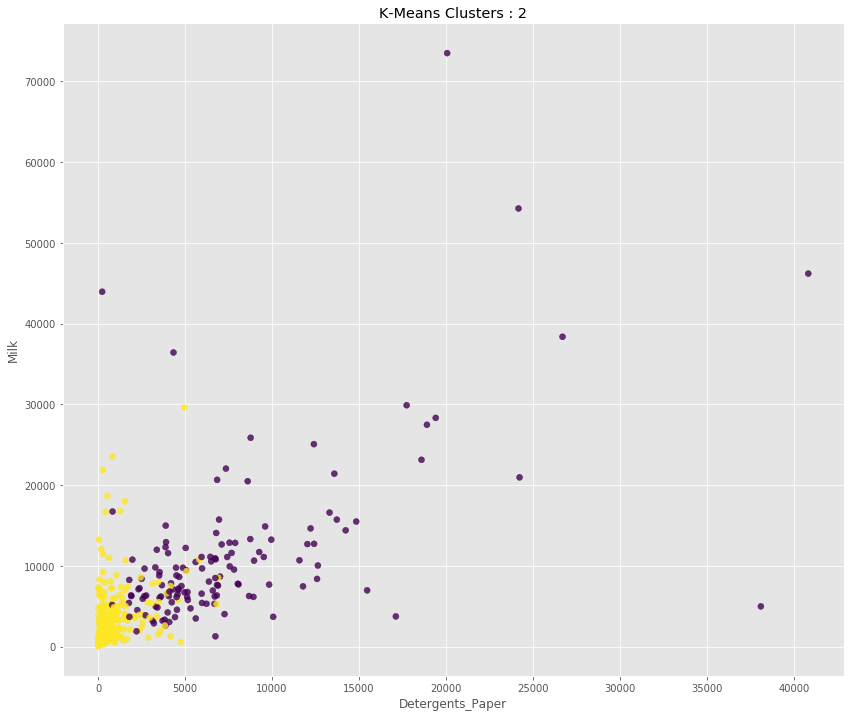

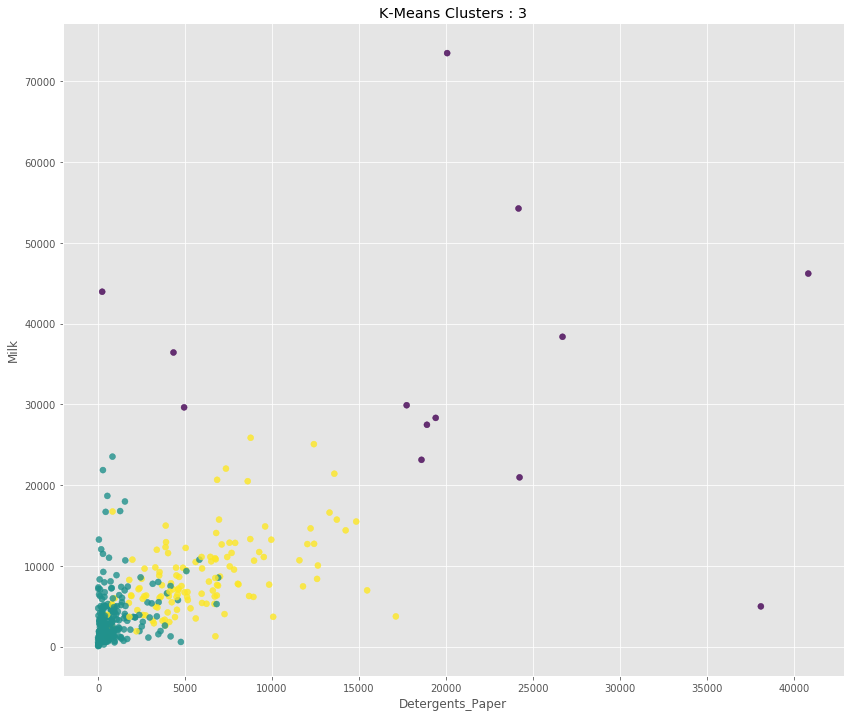

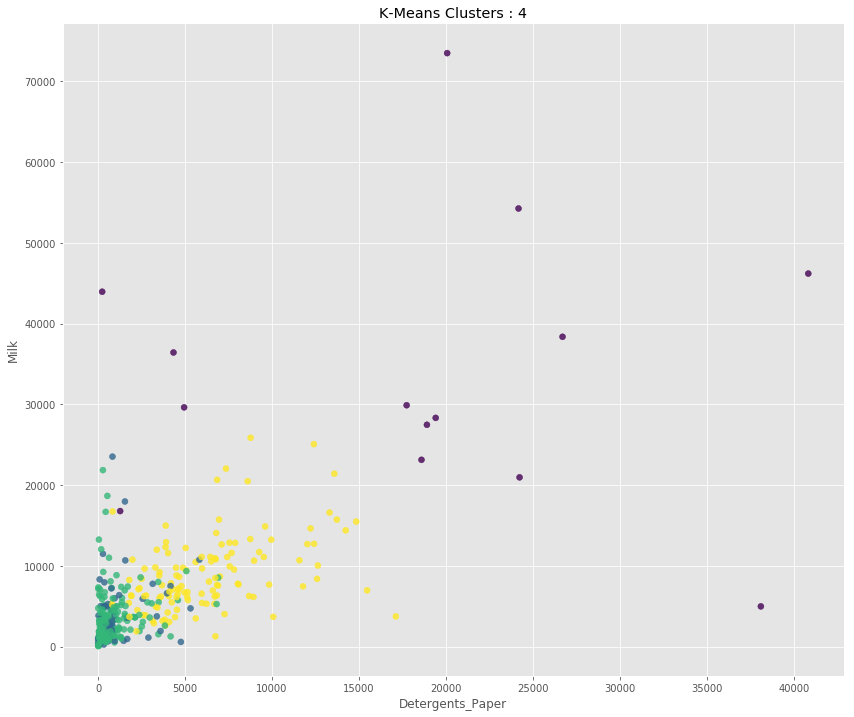

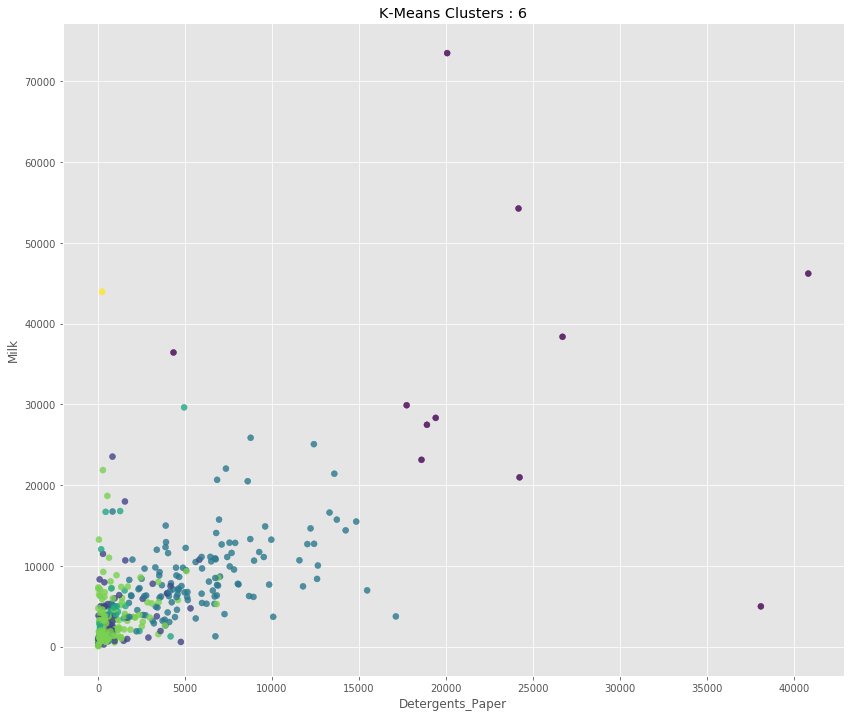

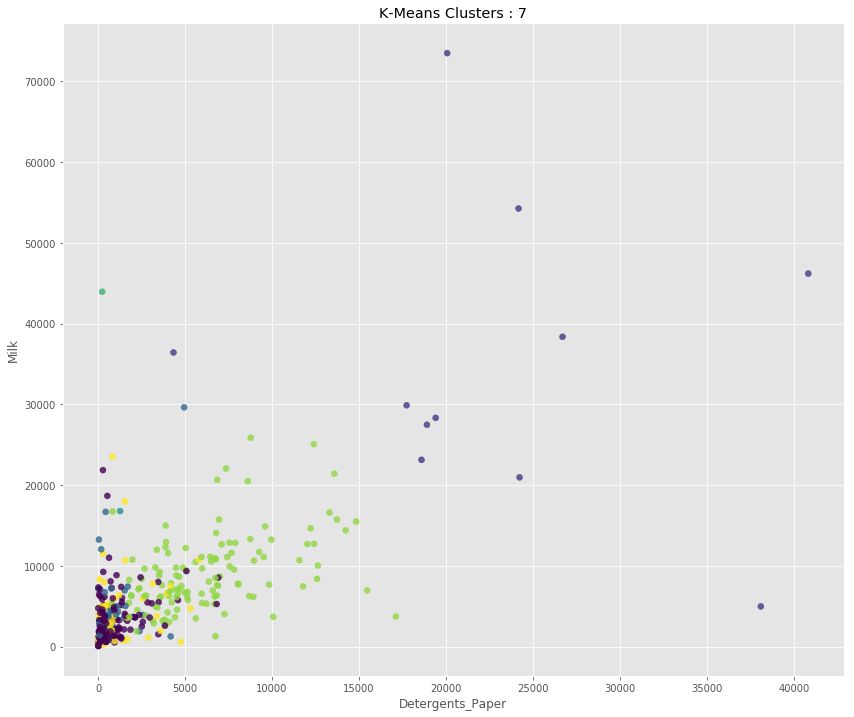

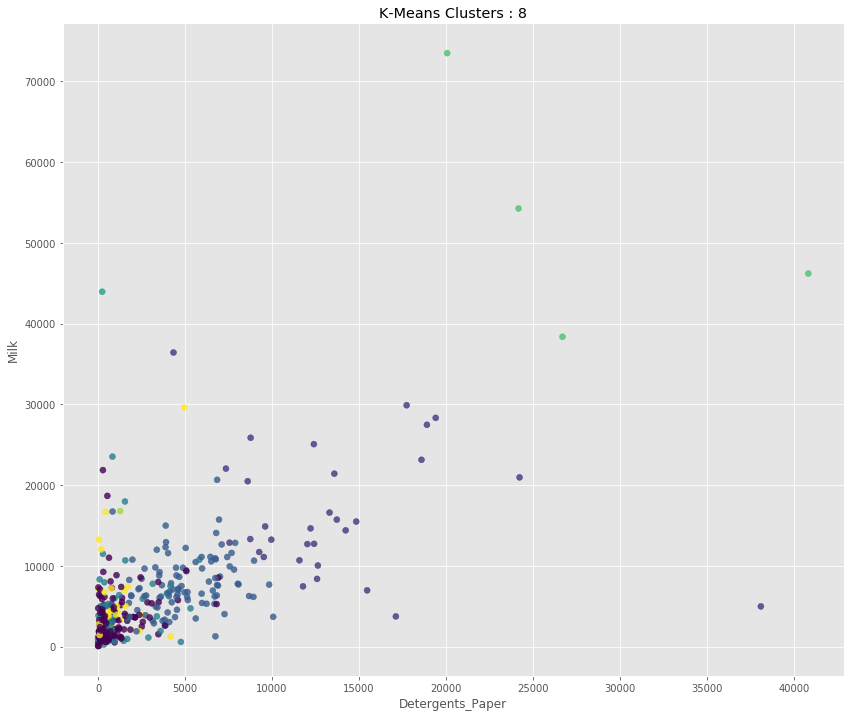

In [206]:
# Comenzamos a partir de 6, ya que antes se probó con cluster igual a 5

columnas = [customers['Detergents_Paper'], customers['Milk']]
graficas_kmean(columnas)

In [129]:
# Your comment here
# Dependiendo del cluster utilizado se diferencia mejor o peor, no por ser mayor el cluster la separación es mejor

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [138]:
# Your code here
def graficas_dbscan(columnas, eps_list = [0.1, 0.2, 0.3, 0.4, 0.5],  min_samples_list = [5,6,7,8,9]):
    '''
    Representa tantas gráficas como clusters pasados
    '''
    
    for i in range(len(eps_list)):
        for j in range(len(min_samples_list)):
            dbscan = DBSCAN(eps = eps_list[i], min_samples = min_samples_list[j])
            temp_dbscan = dbscan.fit(customers_scale)
            customers['labels_DBSCAN'] = temp_dbscan.labels_

            plt.style.use('ggplot')
            plt.figure(figsize = (14,12))
            plt.scatter(columnas[0], 
                        columnas[1], 
                        c = customers['labels_DBSCAN'], alpha = 0.8)
            plt.title('DBSCAN eps: {} - min_samples: {}'.format(eps_list[i], min_samples_list[j]))
            plt.xlabel(columnas[0].name)
            plt.ylabel(columnas[1].name)
            plt.show()

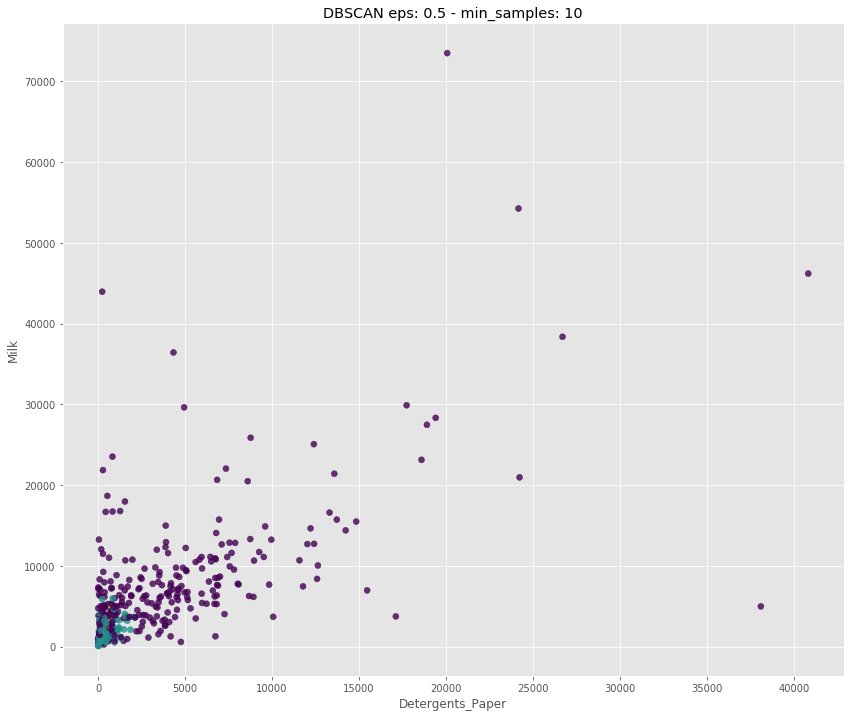

In [197]:
columnas = [customers['Detergents_Paper'], customers['Milk']]
graficas_dbscan(columnas, [0.5], [10])

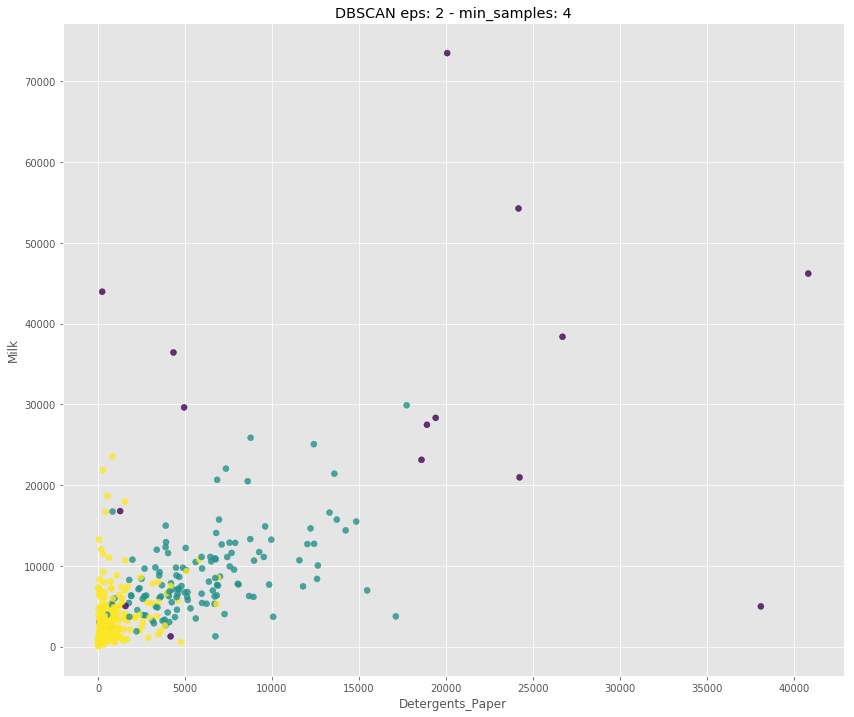

In [184]:
columnas = [customers['Detergents_Paper'], customers['Milk']]
graficas_dbscan(columnas, [2], [4])

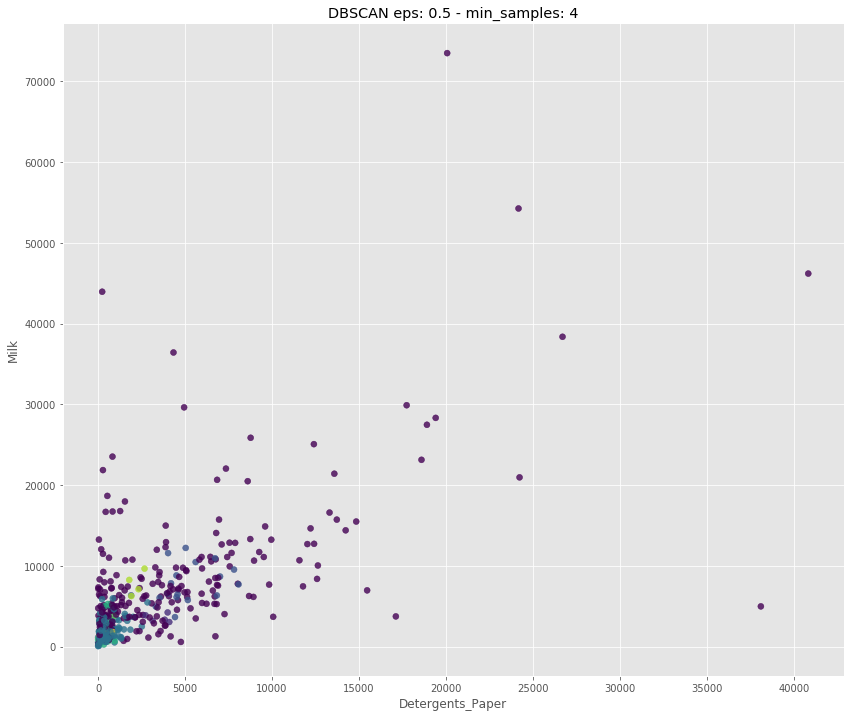

In [181]:
columnas = [customers['Detergents_Paper'], customers['Milk']]
graficas_dbscan(columnas, [0.5], [4])

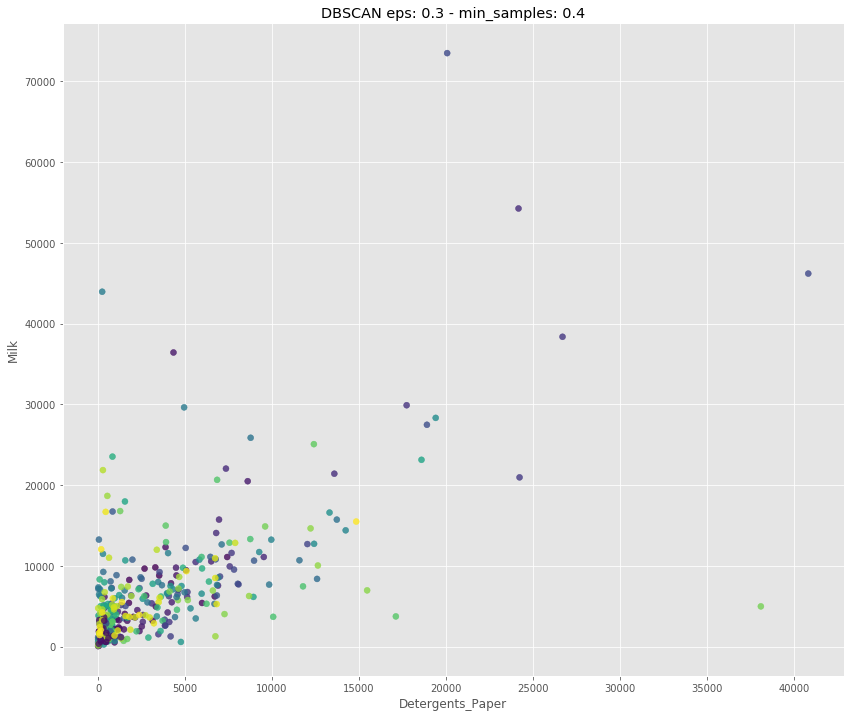

In [194]:
columnas = [customers['Detergents_Paper'], customers['Milk']]
graficas_dbscan(columnas, [0.3], [0.4])

In [ ]:
# Your comment here
# Cuando eps es mayor mejor se distinguen los puntos
# Cuando min_samples es menor mejor se distinguen los puntos
# Pero si alguno de los dos tiene un valor muy superior al otro, en este caso empeora el resultado